# Import module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string
import pickle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import data

In [2]:
df1 = pd.read_csv('./email.csv')

In [3]:
df2 = pd.read_csv('./spam_ham_dataset.csv')

In [4]:
df1.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df2.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
df2 = df2.drop(df2.columns[[0, 3]], axis=1)

In [7]:
df2.head(5)

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [8]:
df2.columns = ['Category','Message']

In [9]:
df = pd.concat([df1, df2], ignore_index=True)
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
10739,ham,Subject: put the 10 on the ft\r\nthe transport...
10740,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...
10741,ham,Subject: calpine daily gas nomination\r\n>\r\n...
10742,ham,Subject: industrial worksheets for august 2000...


# Preprocessing

In [10]:
# Load English stopwords
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Tokenize words
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['Message'] = df['Message'].apply(preprocess_text)
df

,Category,Message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though
...,...,...
10739,ham,subject put 10 ft transport volumes decreased ...
10740,ham,subject 3 4 2000 following noms hpl take extra...
10741,ham,subject calpine daily gas nomination julie men...
10742,ham,subject industrial worksheets august 2000 acti...


In [11]:
df.shape

(10744, 2)

In [12]:
# Find unique Category
df['Category'].value_counts()

ham               8497
spam              2246
{"mode":"full"       1
Name: Category, dtype: int64

In [13]:
# Remove rows with invalid categories
valid_categories = ['ham', 'spam']
df = df[df['Category'].isin(valid_categories)]
df.shape

(10743, 2)

In [14]:
# Encode the 'Category' column: 0 for ham, 1 for spam
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

In [15]:
df

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though
...,...,...
10739,0,subject put 10 ft transport volumes decreased ...
10740,0,subject 3 4 2000 following noms hpl take extra...
10741,0,subject calpine daily gas nomination julie men...
10742,0,subject industrial worksheets august 2000 acti...


In [16]:
# Drop duplicates row
df.drop_duplicates(inplace=True)
df

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though
...,...,...
10737,1,subject slutty milf wants meet take ilaa liqaa
10739,0,subject put 10 ft transport volumes decreased ...
10740,0,subject 3 4 2000 following noms hpl take extra...
10742,0,subject industrial worksheets august 2000 acti...


In [17]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

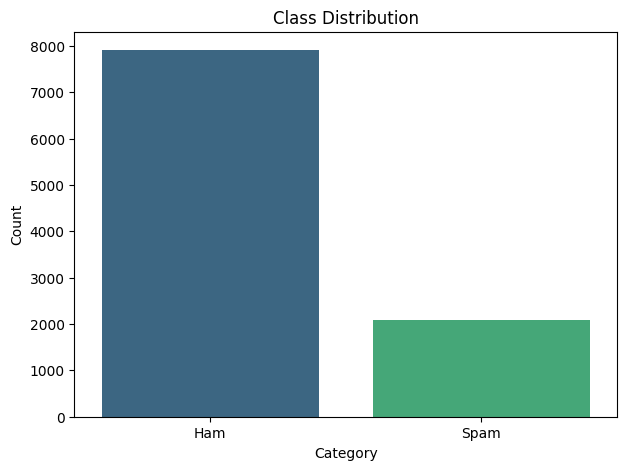

In [18]:
# Plot class distribution
plt.figure(figsize=(7,5))
sns.countplot(x='Category', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

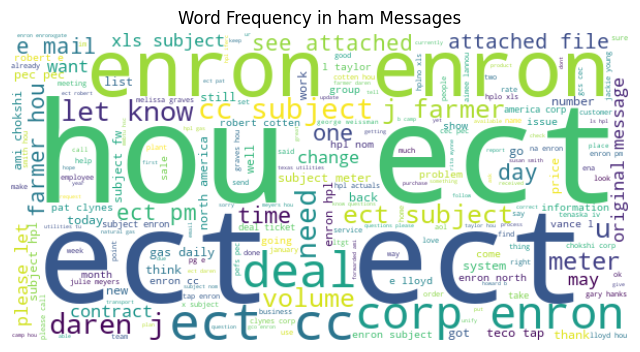

In [19]:
hamtext = ' '.join(df[df['Category'] == 0]['Message'])

# Generate a word cloud
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(hamtext)

# Display the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency in ham Messages')
plt.show()

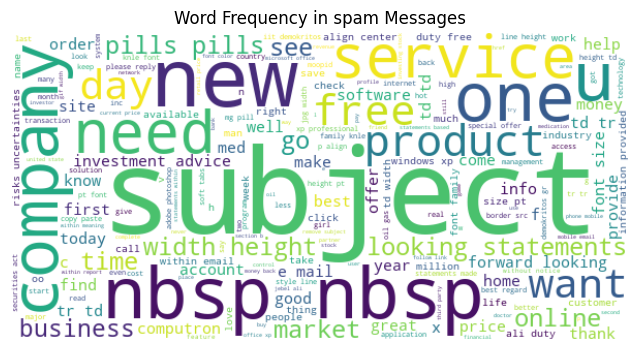

In [20]:
spamtext = ' '.join(df[df['Category'] == 1]['Message'])

# Generate a word cloud
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(spamtext)

# Display the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency in spam Messages')
plt.show()

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = df['Message']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test = tfidf_vectorizer.transform(X_test).toarray()

<Figure size 800x600 with 0 Axes>

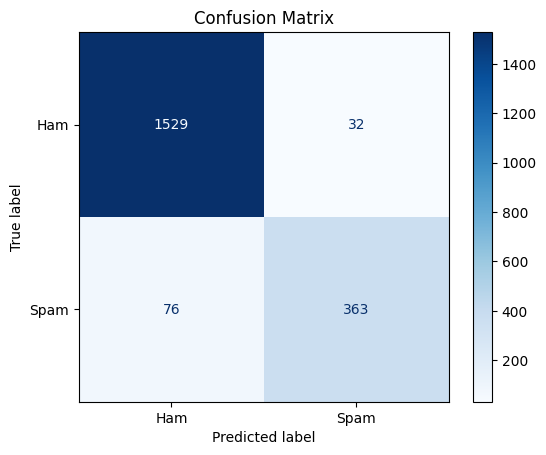

Naive Bayes Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1561
           1       0.92      0.83      0.87       439

    accuracy                           0.95      2000
   macro avg       0.94      0.90      0.92      2000
weighted avg       0.95      0.95      0.94      2000

Naive Bayes saved as Naive Bayes_model.pkl




<Figure size 800x600 with 0 Axes>

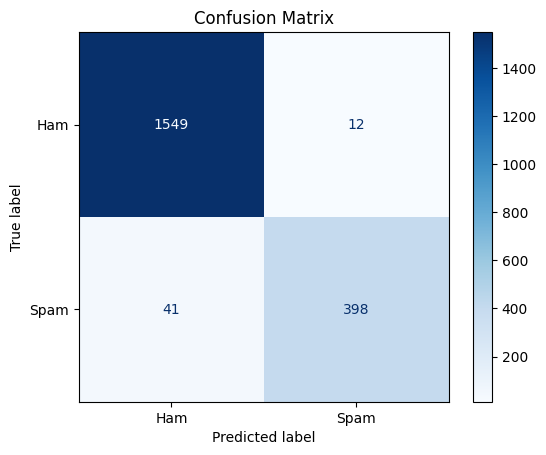

SVM Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1561
           1       0.97      0.91      0.94       439

    accuracy                           0.97      2000
   macro avg       0.97      0.95      0.96      2000
weighted avg       0.97      0.97      0.97      2000

SVM saved as SVM_model.pkl




<Figure size 800x600 with 0 Axes>

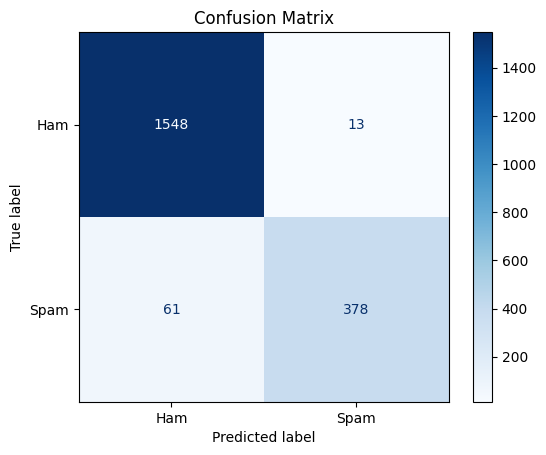

Random Forest Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1561
           1       0.97      0.86      0.91       439

    accuracy                           0.96      2000
   macro avg       0.96      0.93      0.94      2000
weighted avg       0.96      0.96      0.96      2000

Random Forest saved as Random Forest_model.pkl




In [23]:
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results_accuracy = {}
results_precision = {}
results_f1_score = {}
results_recall = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

    results_accuracy[model_name] = accuracy
    results_precision[model_name] = precision
    results_f1_score[model_name] = f1
    results_recall[model_name] = recall
    
    # Menyimpan model menggunakan pickle
    model_filename = f"{model_name}_model.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"{model_name} saved as {model_filename}\n\n")


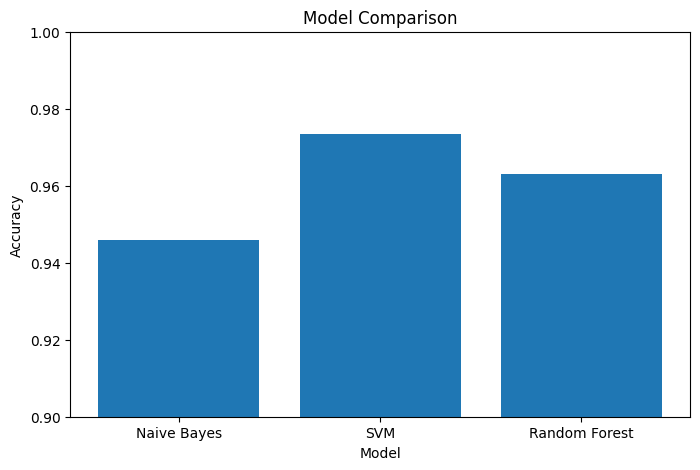

In [24]:
plt.figure(figsize=(8, 5))
plt.bar(results_accuracy.keys(), results_accuracy.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.show()

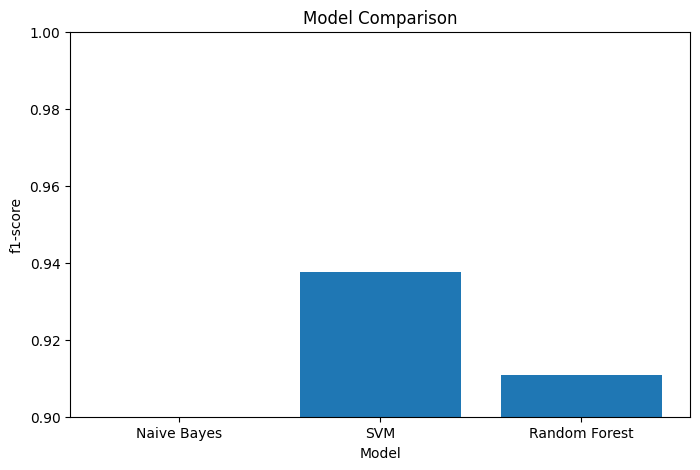

In [25]:
plt.figure(figsize=(8, 5))
plt.bar(results_f1_score.keys(), results_f1_score.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('f1-score')
plt.ylim(0.9, 1.0)
plt.show()

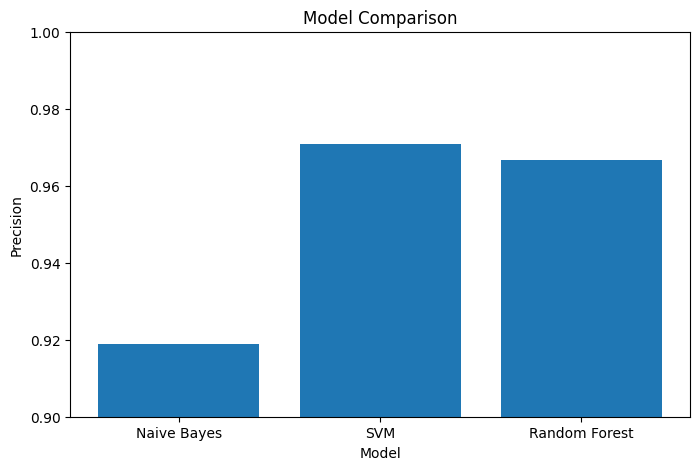

In [26]:
plt.figure(figsize=(8, 5))
plt.bar(results_precision.keys(), results_precision.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim(0.9, 1.0)
plt.show()

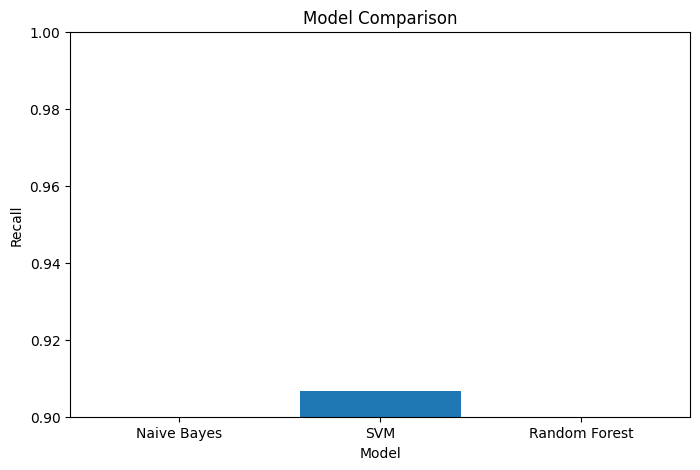

In [27]:
plt.figure(figsize=(8, 5))
plt.bar(results_recall.keys(), results_recall.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.ylim(0.9, 1.0)
plt.show()